In [1]:
## --- plotting functions for website -------------------------------------------------------

# import library
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
%matplotlib inline 

In [2]:
## plot monthly series
def plot_bls_monthly(state):

    df = pd.read_csv(os.getcwd() + "/csv/" + state + ".csv")
    unemp = df["unemployment"]
    emp = df["employment"]

    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.subplots_adjust(right=3, top=3, bottom=2)
    
    plt.subplot(131)
    plt.plot(list(range(0,142)),unemp[0:143])
    # x axis
    plt.xlim((0,143))
    # plt.xticks(range(2005,2016)) # x label rename ?
    # title
    plt.title(state + " monthly unemployment", y=1.00, fontsize = 13)
    
    plt.subplot(132)
    plt.plot(list(range(0,142)),emp[0:143])
    # x axis
    plt.xlim((0,143))
    # plt.xticks(range(2005,2016)) # x label rename ?
    # title
    plt.title(state + " monthly employment", y=1.00, fontsize = 13)
    
    
    plt.subplot(133)
    plt.plot(unemp[0:143]/(unemp[0:143]+emp[0:143]))
    plt.xlim((0,143))
    plt.title(state + " monthly unemployment rate")
    
    pass

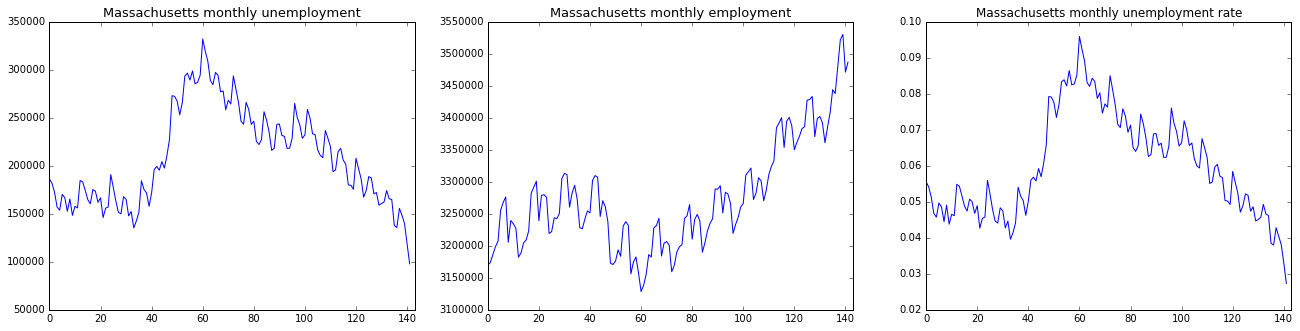

In [3]:
plot_bls_monthly("Massachusetts") # notice seasonal components & almost identitcal unemployment and unemployment rate trend

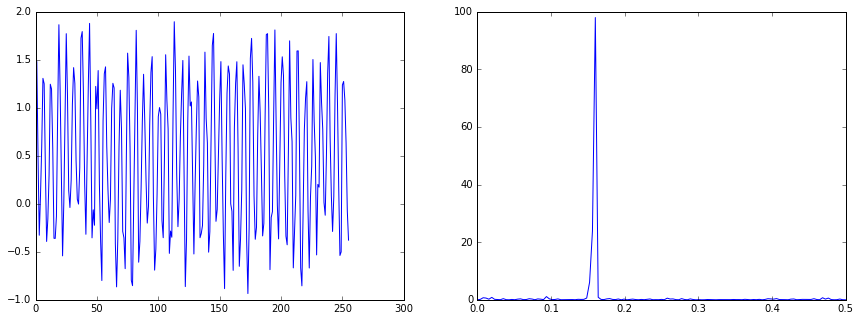

In [4]:
# test seasonality in monthly series with periodogram i.e. spectral density
# time series analysis with seasonal non-stationary times series needs checking
# 1.finding trend 2.finding seasonality 3. ARMA structure by ACF and PACF 4. fitting SARIMA model 5. prediction or residual analysis
# I am not sure they can be done autonomously or at least I can't think of anys of 
# but finding seasonality can be done autonomously by periodogram
# first testing scipy spectral

import scipy as sp
from scipy.signal import spectral

y = np.cos(np.array(range(256)) ) + np.random.rand(256)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(right=2, top=3, bottom=2)
plt.subplot(121)
plt.plot(range(256),y)

plt.subplot(122)
f, t, Sxx = sp.signal.spectrogram(y, fs=1, nperseg=256)
plt.plot(f,Sxx)

In [5]:
1 / f[np.argmax(Sxx)] # period based on estimated spectral density 

6.2439024390243905

In [6]:
2*np.pi # 2 pi

6.283185307179586

In [7]:
# visualize seasonality with periodogram

def plot_seasonal(state):
    # reading csv file slice and make index with pandas datatime for easy plotting
    df = pd.read_csv("monthly_unemployment_rate.csv", index_col="state")
    # subset relevant state and "convert" as a 145 by 2 (index also as column) dataframe with datetime index
    urate = df.loc[state]
    df_date = pd.DataFrame(urate, index = urate.index)
    df_date.set_index(pd.to_datetime(df_date.index), inplace = True)

    fig, axarr = plt.subplots(2, 2)
    fig.subplots_adjust(right=2, top=3, bottom=2)

    axarr[0, 0].plot(df_date[state]) #, ls="dotted", marker="o", markersize=2)
    axarr[0, 0].set_title(state + " monthly unemployment rate")

    # plot periodogram i.e. spectral density
    # subset 2016 Jan to Oct otherwise period inconsistent
    urate = urate[0:132] 

    f, t, Sxx = sp.signal.spectrogram(urate, fs=1, nperseg=len(urate))
    # ax.plot(f, Sxx, marker="o")
    axarr[0, 1].plot(f, Sxx, marker="o")

    # subplots in matplot hmm.......
    # has to be assigned to "ax" for not overriding to plot adjustment such as plt.xlim to following subplots
    # but assigning ax creates axis tick remove axis ticks to prevent duplicate axis tick
    # ax.set_xticklabels(list([" "," "," "," "," "," "]))
    # ax.set_yticklabels(list([" "," "," "," "," "," "]))
    
    axarr[0, 1].set_xlim = ((-0.5, max(f)))
    axarr[0, 1].set_title(state + " monthly unemployment rate periodogram")

    # save cylic components and write on plot
    # numpy collapse and reverse sort
    flat = Sxx.flatten()
    flat = np.sort(flat)[::-1]
    # y cordinate of text
    # text_ycor = np.linspace(int(max(flat))*0.8, int(max(flat)*0.999),4)
    # for 2 by 2 plots
    text_ycor = np.linspace(int(max(flat))*0.5, int(max(flat)*0.9),4)

    cycle = [] # for saving cyclic components
    for i in range(0,4): # print first 4 cycles

        # continue when reciprocal infinity and numerical error
        if f[int(np.where(Sxx==flat[i])[0])] == 0:
            continue
        else:
            cycle.append(1 / f[int(np.where(Sxx==flat[i])[0])] ) # 1/frequency
            axarr[0, 1].text(0.35, text_ycor[i], str(math.ceil(1 / f[int(np.where(Sxx==flat[i])[0])])) + " month cycle", 
                                        bbox={'facecolor':'lightblue', 'alpha':0.2, 'pad':2}) 
    
    # 1 by 2 and 2 by 2 subplots very different
    # will use this format for django so keeping this way
    
    return(cycle)

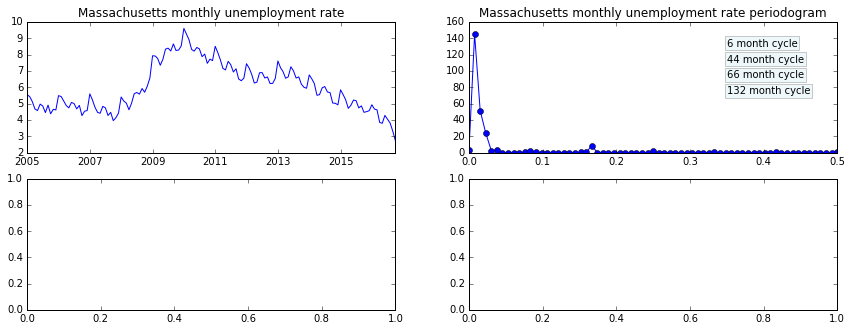

In [8]:
cycle = plot_seasonal("Massachusetts")

In [9]:
cycle

# 131 ~= whole series as cycle with respect to 08 
# 65 ~= 4 year cycle
# 11.9 ~= 12 month i.e. year
# 5.95  ~= 6 month cycle

[132.0, 66.0, 44.0, 5.9999999999999991]

In [10]:
# plot quarterly trend
def plot_bls_quarterly(state, metric = "unemployment"):
    
    df = pd.read_csv("quarterly_" + metric + ".csv", index_col="state")
    
    p = plt.plot(df.loc[state],marker='o',ls="dotted",color="blue") 
    
    plt.xlim((2004.8,2016))
    
    # title
    title_text = state + " quarterly " + metric
    plt.title(title_text, y=1.00, fontsize = 13)

    # xlab and ylab
    
    pass

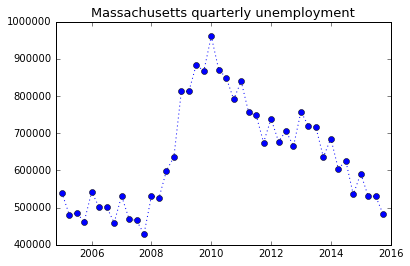

In [11]:
plot_bls_quarterly("Massachusetts", "unemployment")

In [12]:
# auxiliary function for getting percent change approximated by log difference of 1st lags
def get_pchange(array):
    lag1 = list(array)[1::]
    lag0 = list(array)[0:len(lag1)]
    percent_change = np.log(lag1) - np.log(lag0)
    return(percent_change * 100)

In [13]:
# plot unemployment percent change / growth rate
def plot_bls_grate(state, metric = "unemployment"):
    df_bls = pd.read_csv("quarterly_" + metric + ".csv", index_col="state")
    pch = get_pchange(df_bls.loc[state])
    p = plt.plot(df_bls.columns[1:], pch,marker='o',ls="dotted")
    # title
    title_text = state + " quarterly " + metric + " growth rate"
    plt.title(title_text, y=1.00, fontsize = 13)
    # x axis
    plt.xlim((2005,2015.9))
    plt.xticks(range(2005,2016))
    # bar for rates
    plt.bar(list(df_bls.columns[1:]), pch, width=0.1, alpha=0.1)
    return(p)

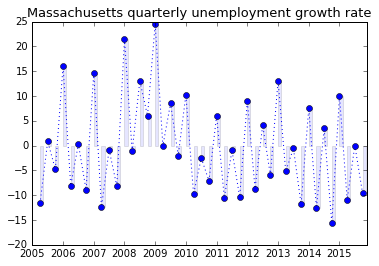

In [14]:
plot_bls_grate("Massachusetts", metric = "unemployment")

In [15]:
# auxiliary function to get unemployment rate ( unemployment/(unemployment+employment) )
def get_urate(state, ts="quarterly"):
    
    df_unemp = pd.read_csv(ts + "_unemployment.csv", index_col="state")  
    unemp = df_unemp.loc[state]
    
    df_emp = pd.read_csv(ts + "_employment.csv", index_col="state") 
    emp = df_emp.loc[state]

    rate = unemp/(unemp+emp)
    return(rate* 100)

In [16]:
get_urate("Massachusetts", "quarterly")[1:5]

2005.25    4.741021
2005.5     4.738507
2005.75    4.548481
2006.0     5.362173
Name: Massachusetts, dtype: float64

In [17]:
get_urate("Massachusetts", "annual")[1:5]

2006    4.893248
2007    4.609244
2008    5.534017
2009    8.107797
Name: Massachusetts, dtype: float64

In [18]:
# plot quarterly unemployment rate
def plot_quarterly_urate(state):
    
    p = plt.plot(get_urate(state,"quarterly"),marker='o',ls= "dotted")
    
    plt.title(state + " quarterly unemployment rate")
    
    # x axis
    plt.xlim((2004.8,2015.9))
    plt.xticks(range(2005,2016))
    
    return(p)

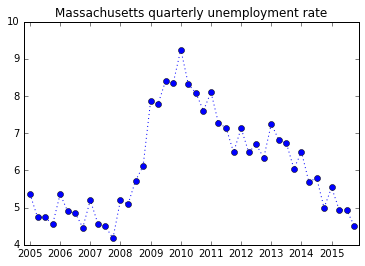

In [19]:
plot_quarterly_urate("Massachusetts")

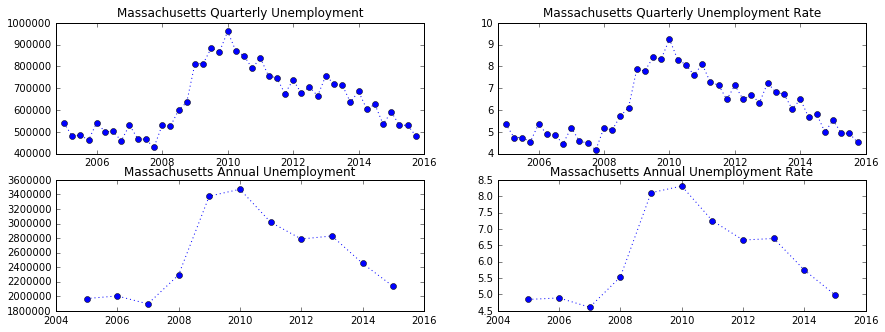

In [20]:
# subplots

state = "Massachusetts"

fig, axes = plt.subplots(nrows=2, ncols=2)

fig.subplots_adjust(right=2, top=3, bottom=2)

df = pd.read_csv("quarterly_unemployment.csv", index_col="state")

# plot1 = df.loc[state].plot(marker='o',ls="dotted",color="blue", ax=axes[0])
# documentations...
plt.subplot(221)
plot1 = plt.plot(df.loc[state], marker='o',ls="dotted",color="blue") 

plt.xlim(2004.75,2016)
# plot1.set_ylim(-0.05, 0.8)
plt.title(state + " Quarterly Unemployment", y=1.01, fontsize = 12)

plt.subplot(222)
plot2 = plt.plot(get_urate(state, "quarterly"),marker='o',ls= "dotted")

plt.xlim(2004.75, 2016)
# plot1.set_ylim(-0.05, 0.8)
plt.title(state + " Quarterly Unemployment Rate", y=1.01, fontsize = 12)

plt.subplot(223)
df = pd.read_csv("annual_unemployment.csv", index_col="state")
plt.plot(df.loc[state], marker='o',ls="dotted",color="blue")
plt.title(state + " Annual Unemployment", fontsize = 12)

plt.subplot(224)
plt.plot(get_urate(state, "annual"),marker='o',ls= "dotted")
plt.title(state + " Annual Unemployment Rate", fontsize = 12)

In [21]:
# unemployment statistics and unemployment rate trend is almost identitcal ?
# presumably total employment is not changing relative to unemployment
# have to compare unemployment rate anyways since other metrics are not scale consistent over states

In [22]:
def plot_urates(state):
    
    fig, axes = plt.subplots(nrows=1, ncols=2)

    fig.subplots_adjust(right=2, top=3, bottom=2)

    df = pd.read_csv("quarterly_unemployment.csv", index_col="state")

    # plot quarterly unemployment rate first window 
    ax = plt.subplot(121)
    plot2 = plt.plot(get_urate(state, "quarterly"),marker='o',ls= "dotted")

    plt.xlim(2004.75, 2016) # plot1.set_ylim(-0.05, 0.8)
    plt.title(state + " Quarterly Unemployment Rate", y=1.01, fontsize = 12)
    # ax.tick_params(labeltop='off', labelright='off') # top tick remove ???

    # plot quarterly annual rate first window 
    plt.subplot(122)
    plt.plot(get_urate(state, "annual"),marker='o',ls= "dotted")
    plt.title(state + " Annual Unemployment Rate", fontsize = 12)
    
    pass

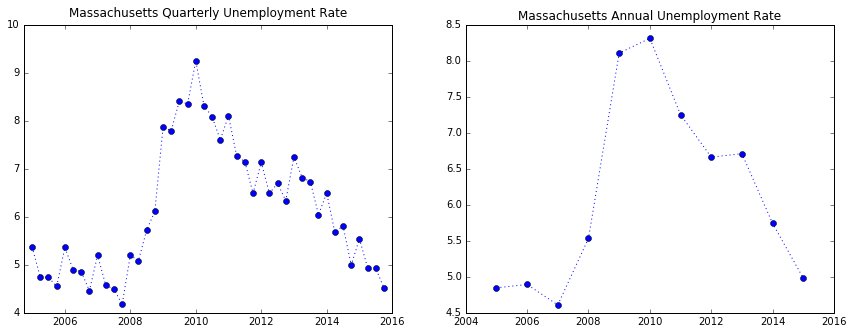

In [23]:
plot_urates("Massachusetts")

In [24]:
# function to plot gdp growth rate vs unemployment rate
def plot_gdpunemp(state):
    # first window : quarterly gdp rate vs unemployment rate
    dir1 = os.getcwd()[0:80] + "/BEA/quarterly_gdp.csv"
    df_gdp = pd.read_csv(dir1, index_col = "state")
    gdp_rate = get_pchange(df_gdp.loc[state]) # call auxiliary function
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.subplots_adjust(right=2, top=3, bottom=2)
    
    plt.subplot(121)
    # first line
    plt.plot(df_gdp.columns[1:], gdp_rate, ls="dotted", color="red", marker = "o",label="GDP growth rate")
    
    # adjusting plot window
    plt.xlim((2005,2016.2))
    plt.xticks(range(2005,2016))
    temp = np.concatenate((get_urate(state, "quarterly"), gdp_rate), axis=0)
    plt.ylim(min(temp)-3, max(temp)+3)
    
    # horizontal line
    plt.axhline(y=0, color="black", ls="dotted") 
    
    # second line
    plt.plot(get_urate(state, "quarterly"), marker='o', ls= "dotted", label="unemployment rate")
    fig = plt.gcf()
    leg = plt.legend(fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
    # secon window : annual
    dir1 = os.getcwd()[0:80] + "/BEA/annual_gdp.csv"
    df_gdp = pd.read_csv(dir1, index_col = "state")
    gdp_rate = get_pchange(df_gdp.loc[state]) # call auxiliary function

    plt.subplot(122)    
    plt.plot(df_gdp.columns[1:], gdp_rate, ls="dotted", color="red", marker = "o",label="GDP growth rate")
    plt.xlim((2005,2016.2))
    plt.xticks(range(2005,2016))
 
    temp = np.concatenate((get_urate(state, "annual"), gdp_rate), axis=0)
    plt.ylim(min(temp)-3, max(temp)+3)

    plt.axhline(y=0, color="black", ls="dotted") # horizontal line

    plt.plot(get_urate(state, "annual"), marker='o', ls= "dotted", label="unemployment rate")
    fig = plt.gcf()
    leg = plt.legend(fontsize=8)
    leg.get_frame().set_linewidth(0.0)

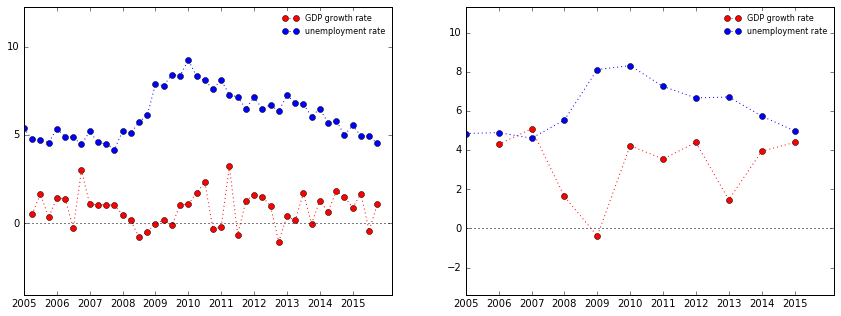

In [25]:
plot_gdpunemp("Massachusetts")

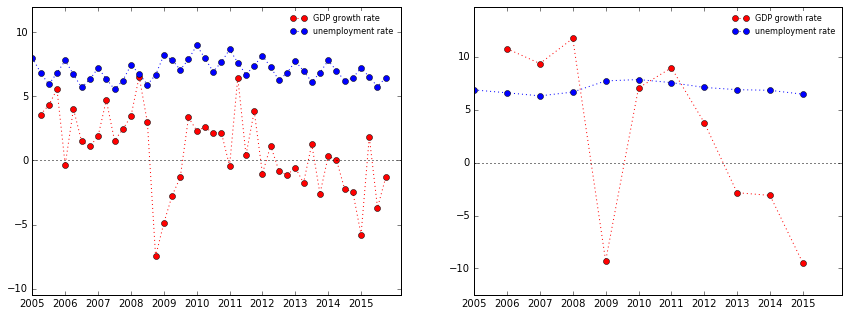

In [26]:
plot_gdpunemp("Alaska") # odd one

In [81]:
# function to plot gdp growth rate vs unemployment rate as scatter plot

def plot_okun(ts = "quarterly"):
    dir1 = os.getcwd()[0:80] + "/BEA/" + ts + "_gdp.csv"
    df_gdp = pd.read_csv(dir1, index_col = "state")
    
    gdp_grate, urate_grate = [], []
    
    # call state names
    states = list(pd.read_csv("BLS_LA_AREACODE.csv")["STATE"])

    # loop over states and append as a single list want 51 * 44 by 1 vector
    # state information are not necessary for this plot
    for state in states:
        gdp_grate.append( list(get_pchange(df_gdp.loc[state])) ) # call auxiliary function
        urate_grate.append( list(get_pchange(get_urate(state, ts))) )
    
    # appended as list of lists need unwrapping
    import itertools
    gdp = list(itertools.chain.from_iterable(gdp_grate))
    urate = list(itertools.chain.from_iterable(urate_grate))
    
    plt.plot(gdp, urate, "o", color = "blue")
    plt.ylim( min(urate)-10, max(urate)+10)
    plt.title(" Okun's Law : " + ts + " precent change GDP and Unemployment Rate")
    
    # pearson correlation
    plt.text(max(gdp)-(max(gdp)-min(gdp))*0.28 ,max(urate)-5, np.corrcoef(gdp, urate)[0, 1])
    

    # return(gdp, urate)

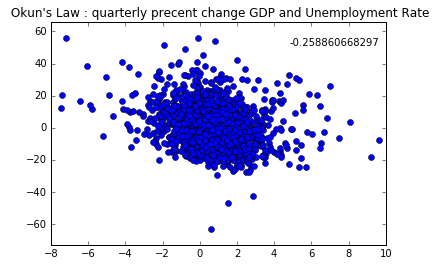

In [82]:
plot_okun("quarterly")

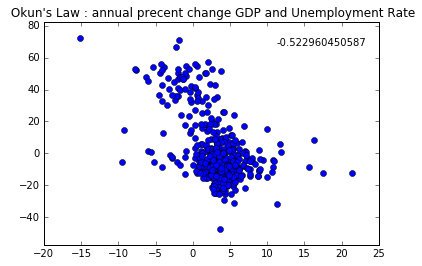

In [83]:
plot_okun("annual")